<a href="https://colab.research.google.com/github/DKund/Structure_Metamodelling/blob/main/SVR_metamodel_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install pyDOE
#!pip install scikit-optimize

In [ ]:
import numpy as np
from pyDOE import lhs
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import pandas as pd

In [ ]:
L = 4
E = 210e9
def deformation_function(b_array, h_array, w_array):
    I_array = (b_array*h_array**3) / 12
    beam_deformation = (w_array*L**3)/(48*E*I_array)
    return beam_deformation

variable_range = {
    'b': (0.2, 1),
    'h': (0.2, 1),
    'w':(15e4, 100e5)
}
np.random.seed(42)
n_initial_sample = 200
n_variables = len(variable_range)
lhs_samples = lhs(n_variables,
                 samples = n_initial_sample,
                 criterion = 'maximin')

x_initial = np.zeros_like(lhs_samples)
for i, (key, (min_val, max_val)) in enumerate(variable_range.items()):
    x_initial[:, i] = min_val + lhs_samples[:, i] * (max_val - min_val)

b_array = x_initial[:, 0]
h_array = x_initial[:, 1]
w_array = x_initial[:, 2]
y_initial = deformation_function(b_array, h_array, w_array)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

param_space = {
    'svr__C': Real(1e-3, 1e3),
    'svr__epsilon': Real(1e-4, 1e1),
    'svr__gamma': Real(1e-4, 1e0),
    'svr__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'svr__degree': Integer(2, 5)
}

cv = KFold(n_splits=5,
          shuffle=True,
          random_state=42)

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    n_iter=50,
    cv=cv,
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(x_initial, y_initial)
print('Best hyperparameters:', bayes_search.best_params_)
best_svr_model = bayes_search.best_estimator_

Best hyperparameters: OrderedDict([('svr__C', 1000.0), ('svr__degree', 2), ('svr__epsilon', 0.0001), ('svr__gamma', 1.0), ('svr__kernel', 'rbf')])


In [ ]:
x_scaler = StandardScaler()
x_initial_scaled = x_scaler.fit_transform(x_initial)
n_iterations = 10
n_new_samples = 20
x_total = x_initial
y_total = y_initial

for iteration in range(n_iterations):

    n_candidate = 100
    candidates_samples = np.random.rand(n_candidate, n_variables)
    x_candidates = np.zeros_like(candidates_samples)
    for i, (key, (min_val, max_val)) in enumerate(variable_range.items()):
        x_candidates[:, i] = min_val + (max_val - min_val)*candidates_samples[:, i]

    x_candidates_scaled = x_scaler.transform(x_candidates)
    y_pred = best_svr_model.predict(x_candidates_scaled)
    y_mean_values = np.mean(y_pred)
    uncertainty = np.abs(y_pred - y_mean_values)
    indices = np.argsort(-uncertainty)[:n_new_samples]

    x_new_samples = x_candidates[indices]
    b_array = x_new_samples[:, 0]
    h_array = x_new_samples[:, 1]
    w_array = x_new_samples[:, 2]
    y_new_samples = deformation_function(b_array, h_array, w_array)

    x_total = np.vstack((x_total, x_new_samples))
    y_total = np.concatenate((y_total, y_new_samples))

    x_scaler.fit(x_total)
    x_total_scaled = x_scaler.transform(x_total)
    best_svr_model.fit(x_total_scaled, y_total)
    print(f'Iteration {iteration + 1}/{n_iterations} completed')

n_validation_sample = 50
lhs_validation = lhs(n_variables,
                    samples=n_validation_sample,
                    criterion='maximin')

x_validation = np.zeros_like(lhs_validation)
for i, (key, (min_val, max_val)) in enumerate(variable_range.items()):
    x_validation[:, i] = min_val + (max_val - min_val)*lhs_validation[:, i]

b_array = x_validation[:, 0]
h_array = x_validation[:, 1]
w_array = x_validation[:, 2]
y_validation = deformation_function(b_array, h_array, w_array)

x_validation_scaled = x_scaler.transform(x_validation)
y_pred_validation = best_svr_model.predict(x_validation_scaled)

MSE = mean_squared_error(y_validation, y_pred_validation)
r2_score_val = r2_score(y_validation, y_pred_validation)
print(f'MSE: {MSE:.4e}')
print(f"Validation R^2 Score: {r2_score_val:.4f}")

Iteration 1/10 completed
Iteration 2/10 completed
Iteration 3/10 completed
Iteration 4/10 completed
Iteration 5/10 completed
Iteration 6/10 completed
Iteration 7/10 completed
Iteration 8/10 completed
Iteration 9/10 completed
Iteration 10/10 completed
MSE: 5.4009e-06
Validation R^2 Score: 0.9947


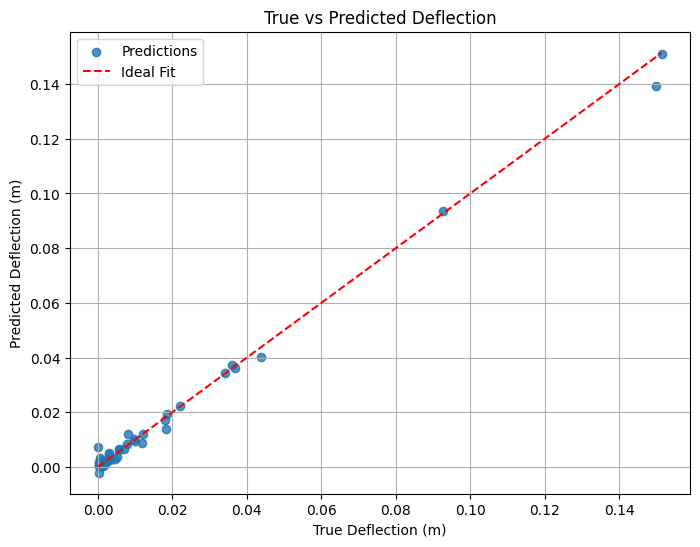

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_validation,
            y_pred_validation,
            alpha=.8,
            label='Predictions')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Ideal Fit')
plt.xlabel('True Deflection (m)')
plt.ylabel('Predicted Deflection (m)')
plt.title('True vs Predicted Deflection')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
file_path = "/content/drive/My Drive/Colab Notebooks/Concrete_Strength_Data.csv"
concrete_data = pd.read_csv(file_path)
concrete_data.head()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
